In [1]:
from celmech.disturbing_function import *

from sympy import symbols, init_printing, Function,simplify,collect,cos
init_printing()

import numpy as np

from celmech.poincare import Poincare, PoincareHamiltonian

In [2]:
import rebound
def make_sim(pratio):
    mass = 3.e-6
    e0 = 0.07 # initial eccentricity of planets
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=mass, e=e0, P=1.)
    sim.add(m=mass, e=1.e-5, P=pratio, f=np.pi)
    sim.move_to_com()
    return sim     

sim=make_sim(np.sqrt(5))
pvars = Poincare.from_Simulation(sim)
Hsim = PoincareHamiltonian(pvars)

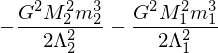

In [3]:
Hsim.H

In [4]:
Hsim.add_secular_terms(1,2)

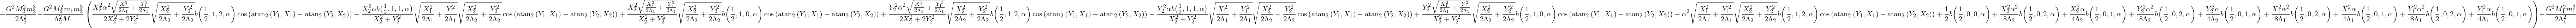

In [5]:
Hsim.H


In [10]:
from sympy import cos,atan,atan2

In [ ]:
cos()

In [16]:
simplify(cos(atan2(S('y1'),S('x1'))-atan2(S('y2'),S('x2'))))

In [15]:
from sympy import hyper

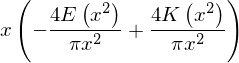

In [21]:
hyperexpand(S('x')*hyper([1/S(2),3/S(2)],[2],S('x')*S('x')))

In [9]:
S.One

In [80]:
class laplace_B(Function):
    nargs=4
    @classmethod
    def eval(cls, s,j,n,alpha):
    # laplace coeffcients don't evaluate well with the C code
    # for large n, therefore I've substituted the exact expression
    # in terms of the elliptic K function when j=0
        if j is S.Zero:
            x = S('x')
            exprn = 4 / np.pi * diff(elliptic_k(x*x),x,n)
            return exprn.subs(x,alpha)

        else:
            return laplace_coefficient(s,j,n,alpha)/ alpha**n

In [51]:
from sympy import a

In [52]:
?lambdify

In [7]:
Hsim._update()
Hsim.NH

TypeError: as_base_exp() missing 1 required positional argument: 'self'

In [4]:
e,e1 = symbols("e_1 e_2")
w,w1 = symbols("varpi_1 varpi_2")
exprn=secular_DF(e,e1,w,w1,4)-secular_DF(e,e1,w,w1,2)

In [59]:
collect(exprn.subs(S('alpha'),0.6).subs(Function('b'),laplace_B),(e,e1))

In [65]:
exprn.subs(e1,0).subs(S('alpha'),0.6).subs(Function('b'),laplace_B)

In [64]:
[(n,laplace_B(1/2,0,n,0.6)) for n in range(1,5)]

In [ ]:
Hsim.